In [1]:
%matplotlib inline
%env SM_FRAMEWORK=tf.keras
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize, rotate
import os
from os.path import join
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import albumentations as A
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
"""AdamP for TensorFlow."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops


class AdamP(optimizer_v2.OptimizerV2):
    _HAS_AGGREGATE_GRAD = True

    def __init__(self,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-8,
                 weight_decay=0.0,
                 delta=0.1, wd_ratio=0.1, nesterov=False,
                 name='AdamP',
                 **kwargs):

        super(AdamP, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('delta', delta)
        self._set_hyper('wd_ratio', wd_ratio)

        self.epsilon = epsilon or backend_config.epsilon()
        self.weight_decay = weight_decay
        self.nesterov = nesterov

    def _create_slots(self, var_list):
        # Create slots for the first and second moments.
        # Separate for-loops to respect the ordering of slot variables from v1.
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')
        for var in var_list:
            self.add_slot(var, 'p')

    def _prepare_local(self, var_device, var_dtype, apply_state):
        super(AdamP, self)._prepare_local(var_device, var_dtype, apply_state)

        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
        beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)

        lr = apply_state[(var_device, var_dtype)]['lr_t']
        bias_correction1 = 1 - beta_1_power
        bias_correction2 = 1 - beta_2_power

        delta = array_ops.identity(self._get_hyper('delta', var_dtype))
        wd_ratio = array_ops.identity(self._get_hyper('wd_ratio', var_dtype))

        apply_state[(var_device, var_dtype)].update(
            dict(
                lr=lr,
                epsilon=ops.convert_to_tensor_v2(self.epsilon, var_dtype),
                weight_decay=ops.convert_to_tensor_v2(self.weight_decay, var_dtype),
                beta_1_t=beta_1_t,
                beta_1_power=beta_1_power,
                one_minus_beta_1_t=1 - beta_1_t,
                beta_2_t=beta_2_t,
                beta_2_power=beta_2_power,
                one_minus_beta_2_t=1 - beta_2_t,
                bias_correction1=bias_correction1,
                bias_correction2=bias_correction2,
                delta=delta,
                wd_ratio=wd_ratio))

    def set_weights(self, weights):
        params = self.weights
        # If the weights are generated by Keras V1 optimizer, it includes vhats
        # optimizer has 2x + 1 variables. Filter vhats out for compatibility.
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(AdamP, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'] + m_scaled_g_values, use_locking=self._use_locking)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'] + v_scaled_g_values, use_locking=self._use_locking)

        denorm = (math_ops.sqrt(v_t) / math_ops.sqrt(coefficients['bias_correction2'])) + coefficients['epsilon']
        step_size = coefficients['lr'] / coefficients['bias_correction1']

        if self.nesterov:
            perturb = (coefficients['beta_1_t'] * m_t + coefficients['one_minus_beta_1_t'] * grad) / denorm
        else:
            perturb = m_t / denorm

        # Projection
        wd_ratio = 1
        if len(var.shape) > 1:
            perturb, wd_ratio = self._projection(var, grad, perturb, coefficients['delta'], coefficients['wd_ratio'], coefficients['epsilon'])

        # Weight decay

        if self.weight_decay > 0:
            var = state_ops.assign(var, var * (1 - coefficients['lr'] * coefficients['weight_decay'] * wd_ratio), use_locking=self._use_locking)

        var_update = state_ops.assign_sub(var, step_size * perturb, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t])


    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):

        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))
        """
        Adam
        """
        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'],
                               use_locking=self._use_locking)
        with ops.control_dependencies([m_t]):
            m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'],
                               use_locking=self._use_locking)
        with ops.control_dependencies([v_t]):
            v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

        denorm = (math_ops.sqrt(v_t) / math_ops.sqrt(coefficients['bias_correction2'])) + coefficients['epsilon']
        step_size = coefficients['lr'] / coefficients['bias_correction1']

        if self.nesterov:
            p_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
            perturb = m_t * coefficients['beta_1_t']
            perturb = self._resource_scatter_add(perturb, indices, p_scaled_g_values) / denorm

        else:
            perturb = m_t / denorm

        # Projection
        wd_ratio = 1
        if len(var.shape) > 1:
            perturb, wd_ratio = self._projection(var, grad, perturb, coefficients['delta'], coefficients['wd_ratio'], coefficients['epsilon'])

        # Weight decay
        if self.weight_decay > 0:
            var = state_ops.assign(var, var * (1 - coefficients['lr'] * coefficients['weight_decay'] * wd_ratio), use_locking=self._use_locking)

        var_update = state_ops.assign_sub(var, step_size * perturb, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t])

    def _channel_view(self, x):
        return array_ops.reshape(x, shape=[x.shape[0], -1])

    def _layer_view(self, x):
        return array_ops.reshape(x, shape=[1, -1])

    def _cosine_similarity(self, x, y, eps, view_func):
        x = view_func(x)
        y = view_func(y)

        x_norm = math_ops.euclidean_norm(x, axis=-1) + eps
        y_norm = math_ops.euclidean_norm(y, axis=-1) + eps
        dot = math_ops.reduce_sum(x * y, axis=-1)

        return math_ops.abs(dot) / x_norm / y_norm

    def _projection(self, var, grad, perturb, delta, wd_ratio, eps):
        # channel_view
        cosine_sim = self._cosine_similarity(grad, var, eps, self._channel_view)
        cosine_max = math_ops.reduce_max(cosine_sim)
        compare_val = delta / math_ops.sqrt(math_ops.cast(self._channel_view(var).shape[-1], dtype=delta.dtype))

        perturb, wd = control_flow_ops.cond(pred=cosine_max < compare_val,
                                            true_fn=lambda : self.channel_true_fn(var, perturb, wd_ratio, eps),
                                            false_fn=lambda : self.channel_false_fn(var, grad, perturb, delta, wd_ratio, eps))

        return perturb, wd

    def channel_true_fn(self, var, perturb, wd_ratio, eps):
        expand_size = [-1] + [1] * (len(var.shape) - 1)
        var_n = var / (array_ops.reshape(math_ops.euclidean_norm(self._channel_view(var), axis=-1), shape=expand_size) + eps)
        perturb -= var_n * array_ops.reshape(math_ops.reduce_sum(self._channel_view(var_n * perturb), axis=-1), shape=expand_size)
        wd = wd_ratio

        return perturb, wd

    def channel_false_fn(self, var, grad, perturb, delta, wd_ratio, eps):
        cosine_sim = self._cosine_similarity(grad, var, eps, self._layer_view)
        cosine_max = math_ops.reduce_max(cosine_sim)
        compare_val = delta / math_ops.sqrt(math_ops.cast(self._layer_view(var).shape[-1], dtype=delta.dtype))

        perturb, wd = control_flow_ops.cond(cosine_max < compare_val,
                                              true_fn=lambda : self.layer_true_fn(var, perturb, wd_ratio, eps),
                                              false_fn=lambda : self.identity_fn(perturb))

        return perturb, wd

    def layer_true_fn(self, var, perturb, wd_ratio, eps):
        expand_size = [-1] + [1] * (len(var.shape) - 1)
        var_n = var / (array_ops.reshape(math_ops.euclidean_norm(self._layer_view(var), axis=-1), shape=expand_size) + eps)
        perturb -= var_n * array_ops.reshape(math_ops.reduce_sum(self._layer_view(var_n * perturb), axis=-1), shape=expand_size)
        wd = wd_ratio

        return perturb, wd

    def identity_fn(self, perturb):
        wd = 1.0

        return perturb, wd

    def get_config(self):
        config = super(AdamP, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'delta': self._serialize_hyperparameter('delta'),
            'wd_ratio': self._serialize_hyperparameter('wd_ratio'),
            'epsilon': self.epsilon,
            'weight_decay': self.weight_decay,
            'nesterov': self.nesterov
        })
        return config

In [3]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(3, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[0].set_title('GT', fontsize=fontsize)
        
        ax[1].imshow(mask)
        ax[1].set_title('model mask', fontsize=fontsize)
        
        ax[2].imshow(original_image)
        ax[2].set_title('Image', fontsize=fontsize)

# Data

In [4]:
data_path = 'public_tests/00_test_val_input/train/images/'
gt_path = 'public_tests/00_test_val_input/train/gt/'

In [5]:
def read_and_resize_data(data_path, gt_path):
    #TAKE = 15
    size = 224
    folders_data = np.array(sorted(os.listdir(data_path)))
    folders_gt = np.array(sorted(os.listdir(gt_path)))
    assert np.all(folders_gt == folders_data)
    folders = folders_data
    images_data = []
    images_gt = []
    for folder in tqdm(folders, desc='reading data folders...'):
        files_data = np.array(sorted(os.listdir(data_path + folder)))
        files_gt = np.array(sorted(os.listdir(gt_path + folder)))
        files_data = [file[:-4] for file in files_data]
        files_gt = [file[:-4] for file in files_gt]
        #print(files_gt, files_data)
        assert np.all(files_gt == files_data)
        files = files_data
        for file in files:
            impath = data_path + folder + '/' + file + '.jpg'
            gtpath = gt_path + folder + '/' + file + '.png'
            image = imread(impath)
            gt = imread(gtpath)
            h, w = image.shape[:2]
            images_data.append(resize(image, (size, size, 3)).astype('float16'))
            positives = (resize(gt, (size, size, 1))).astype('float16')
            negatives = (1 - resize(gt, (size, size, 1))).astype('float16')
            gt = np.stack((negatives, positives), axis=2).reshape((size, size, 2))
            images_gt.append(gt)
    X = np.array(images_data)
    Y = np.array(images_gt)
    return X, Y

In [6]:
X, Y = read_and_resize_data(data_path, gt_path)
X.shape, Y.shape

((8382, 224, 224, 3), (8382, 224, 224, 2))

In [7]:
np.unique(Y)

array([0.000e+00, 5.960e-08, 1.788e-07, ..., 9.990e-01, 9.995e-01,
       1.000e+00], dtype=float16)

In [8]:
X[2].shape

(224, 224, 3)

# Generator

In [9]:
def generator(x_train, y_train, batch_size=128):
    cur = 0
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]
    while True:
        batchx = np.zeros((batch_size, 224, 224, 3))
        batchy = np.zeros((batch_size, 224, 224, 2))
        for i in range(batch_size):
            transform = A.Compose([
                    A.Flip(),
                    A.RandomRotate90(),
                    A.Transpose(),
                    A.OneOf([
                        A.RandomRain(),
                        A.RandomFog(),
                    ], p=0.2),
                    A.GaussNoise(var_limit=(0.0005, 0.005)),
                    #A.Blur(blur_limit=1.5, p=0.1),
                    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=40, p=0.8),
                    A.OneOf([
                        A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                        A.OpticalDistortion(p=0.3),
                        A.GridDistortion(p=.1),
                        A.IAAPiecewiseAffine(p=0.3),
                    ], p=0.2),
                    #A.RandomBrightnessContrast(),            
                ])
            t = transform(image=x_train[cur].astype('float32'), mask=y_train[cur].astype('float32'))
            batchx[i] = np.array(t['image'])
            batchy[i] = np.array(t['mask'])
            cur += 1
            if cur == x_train.shape[0]:
                batchx = batchx[:i+1, :]
                batchy = batchy[:i+1, :]
                indices = np.arange(x_train.shape[0])
                np.random.shuffle(indices)
                x_train = x_train[indices]
                y_train = y_train[indices]
                cur = 0
                break
        yield batchx.astype('float32'), batchy.astype('float32')

0.9397244 0.0


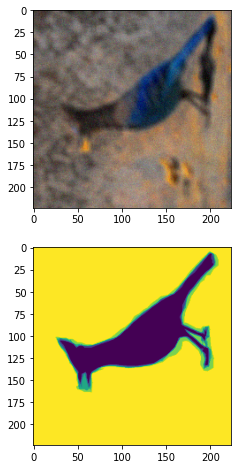

In [10]:
for x, y in generator(X, Y):
    visualize(x[0], y[0][:, :, :1])
    print(np.max(x[0]), np.min(x[0]))
    break

# Training

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [11]:
BACKBONE = 'resnet34'
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=2, activation='softmax', encoder_freeze=True, input_shape=(224, 224, 3))
for i in range(len(model.layers)):
    if model.layers[i].name.startswith('stage4'):
        model.layers[i].trainable = True
#    if 'f_drop' in layer.name:
#        print(layer.name)
model.load_weights('resnet34based.hdf5')
opt = AdamP(learning_rate=0.01, beta_1=0.9, beta_2=0.999, weight_decay=1e-5)
model.compile(
    opt,
    loss=sm.losses.BinaryFocalLoss(),
    metrics=[sm.metrics.IOUScore(threshold=0.5)],
)
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
_______________________________________________________________________________________

In [12]:
batch_size = 16
reducelr = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 20, verbose = 1)
h = model.fit(generator(X, Y, batch_size),
              steps_per_epoch=X.shape[0]//batch_size, epochs=50,
              callbacks=[reducelr])# validation_batch_size=64)
model.save('resnet34based_finetune.hdf5')

Epoch 1/50
523/523 [==============================] - 65s 124ms/step - loss: 0.0115 - iou_score: 0.8759
Epoch 2/50
523/523 [==============================] - 65s 124ms/step - loss: 0.0119 - iou_score: 0.8727
Epoch 3/50
523/523 [==============================] - 67s 127ms/step - loss: 0.0119 - iou_score: 0.8715
Epoch 4/50
523/523 [==============================] - 66s 127ms/step - loss: 0.0120 - iou_score: 0.8713
Epoch 5/50
523/523 [==============================] - 66s 126ms/step - loss: 0.0119 - iou_score: 0.8725
Epoch 6/50
523/523 [==============================] - 68s 130ms/step - loss: 0.0121 - iou_score: 0.8703
Epoch 7/50
523/523 [==============================] - 65s 125ms/step - loss: 0.0118 - iou_score: 0.8736
Epoch 8/50
523/523 [==============================] - 66s 126ms/step - loss: 0.0118 - iou_score: 0.8736
Epoch 9/50
523/523 [==============================] - 64s 123ms/step - loss: 0.0118 - iou_score: 0.8728
Epoch 10/50
523/523 [==============================] - 66s 125ms

In [14]:
batch_size = 16
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
reducelr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 20, verbose = 1)
h = model.fit(generator(X_train, Y_train, batch_size),
              validation_data=(X_test, Y_test),
              steps_per_epoch=X_train.shape[0]//batch_size, epochs=300,
              callbacks=[reducelr])# validation_batch_size=64)
model.save('resnet34based.hdf5')

Epoch 1/300
471/471 [==============================] - 121s 257ms/step - loss: 0.0229 - iou_score: 0.7518 - val_loss: 0.0496 - val_iou_score: 0.5479
Epoch 2/300
471/471 [==============================] - 60s 128ms/step - loss: 0.0170 - iou_score: 0.8209 - val_loss: 0.0526 - val_iou_score: 0.5311
Epoch 3/300
471/471 [==============================] - 59s 126ms/step - loss: 0.0165 - iou_score: 0.8275 - val_loss: 0.0522 - val_iou_score: 0.7448
Epoch 4/300
471/471 [==============================] - 59s 125ms/step - loss: 0.0157 - iou_score: 0.8337 - val_loss: 0.0139 - val_iou_score: 0.8587
Epoch 5/300
471/471 [==============================] - 62s 131ms/step - loss: 0.0157 - iou_score: 0.8336 - val_loss: 0.0135 - val_iou_score: 0.8659
Epoch 6/300
471/471 [==============================] - 59s 126ms/step - loss: 0.0150 - iou_score: 0.8416 - val_loss: 0.0146 - val_iou_score: 0.8281
Epoch 7/300
471/471 [==============================] - 59s 125ms/step - loss: 0.0157 - iou_score: 0.8340 - val_

Epoch 108/300
471/471 [==============================] - 59s 125ms/step - loss: 0.0113 - iou_score: 0.8777 - val_loss: 0.0096 - val_iou_score: 0.8938
Epoch 109/300
471/471 [==============================] - 60s 127ms/step - loss: 0.0113 - iou_score: 0.8793 - val_loss: 0.0098 - val_iou_score: 0.8905
Epoch 110/300
471/471 [==============================] - 61s 129ms/step - loss: 0.0113 - iou_score: 0.8789 - val_loss: 0.0097 - val_iou_score: 0.8947
Epoch 111/300
471/471 [==============================] - 59s 125ms/step - loss: 0.0112 - iou_score: 0.8782 - val_loss: 0.0095 - val_iou_score: 0.8953
Epoch 112/300
471/471 [==============================] - 59s 126ms/step - loss: 0.0112 - iou_score: 0.8794 - val_loss: 0.0097 - val_iou_score: 0.8910
Epoch 113/300
471/471 [==============================] - 59s 125ms/step - loss: 0.0113 - iou_score: 0.8786 - val_loss: 0.0095 - val_iou_score: 0.8957
Epoch 114/300
471/471 [==============================] - 59s 126ms/step - loss: 0.0111 - iou_score: 

471/471 [==============================] - 59s 125ms/step - loss: 0.0103 - iou_score: 0.8899 - val_loss: 0.0089 - val_iou_score: 0.9035
Epoch 213/300
471/471 [==============================] - 59s 125ms/step - loss: 0.0102 - iou_score: 0.8896 - val_loss: 0.0089 - val_iou_score: 0.9033
Epoch 214/300
471/471 [==============================] - 60s 128ms/step - loss: 0.0102 - iou_score: 0.8889 - val_loss: 0.0089 - val_iou_score: 0.9034
Epoch 215/300
471/471 [==============================] - 60s 127ms/step - loss: 0.0103 - iou_score: 0.8891 - val_loss: 0.0089 - val_iou_score: 0.9030
Epoch 216/300
471/471 [==============================] - 59s 125ms/step - loss: 0.0102 - iou_score: 0.8895 - val_loss: 0.0089 - val_iou_score: 0.9032
Epoch 217/300
471/471 [==============================] - 58s 123ms/step - loss: 0.0102 - iou_score: 0.8887 - val_loss: 0.0089 - val_iou_score: 0.9036
Epoch 218/300
471/471 [==============================] - ETA: 0s - loss: 0.0103 - iou_score: 0.8891
Epoch 00218: R

In [18]:
model.save('try5.hdf5')

# Eval

In [7]:
BACKBONE = 'resnet34'
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=2, activation='softmax', encoder_freeze=True, input_shape=(224, 224, 3))
model.summary()
model.load_weights('resnet34based_finetune.hdf5')
model.compile('adam', 'categorical_crossentropy', metrics='accuracy')
model.save('resnet_norm_finetune.hdf5')

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
_______________________________________________________________________________________

In [8]:
model = tf.keras.models.load_model('resnet_norm_finetune.hdf5')
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
_______________________________________________________________________________________

In [9]:
y = model.predict(X)

In [10]:
y.shape, Y.shape

((8382, 224, 224, 2), (8382, 224, 224, 2))

In [11]:
def get_iou(gt, pred):
    return (gt & pred).sum() / (gt | pred).sum()

0.9511608450115039


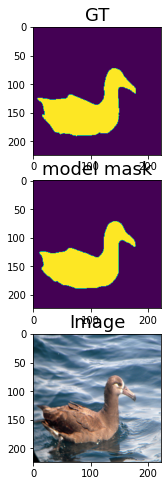

In [21]:
i = 0
visualize(Y[i][:, :, 1:]> 0.5, (y[i][:, :, 1:] > 0.5), X[i].astype('float32'))
print(get_iou((Y[i][:, :, 1:]> 0.5), (y[i][:, :, 1:] > 0.5)))
#plt.imshow(X[i].astype('float32'))
#plt.imshow((Y[i][:, :, 1:] > 0.5))

In [13]:
arr = []
for i in range(8382):
    #i = 34
    #visualize(Y_test[i][:, :, 1:].astype(int), (y[i][:, :, 1:] > 0.5))
    iou = get_iou(Y[i][:, :, 1:] > 0.5, (y[i][:, :, 1:] > 0.5))
    arr.append(iou)
    if iou < 0.5:
        print(i, iou)
    #print(arr[-1])
print(np.mean(arr))

105 0.49274809160305344
155 0.48473967684021546
158 0.360149236329719
183 0.32834487379941923
194 0.28771929824561404
249 0.3155053358443189
268 0.23784254023488474
321 0.25071664829106943
383 0.43903940886699505
475 0.48094877617966186
604 0.4788285109386027
755 0.43307314252674184
839 0.4149494556765163
873 0.25851293103448275
875 0.12624233453161346
1235 0.3888583470771486
1330 0.4792105263157895
1502 0.35195416410886027
1612 0.20112907855707587
2111 0.45419187554019014
2135 0.3160044559970293
2171 0.4217718059667502
2183 0.43729754743174454
2401 0.4270907791279485
2686 0.3641940881204685
2779 0.21103217718345174
2796 0.20721311475409837
2811 0.42057761732851984
3409 0.0
3577 0.32061440936242835
3812 0.3982311755312615
4176 0.4573444515715202
4304 0.045898852528686786
4340 0.362791658063184
4345 0.44107821679530007
4784 0.0
4990 0.440625
5139 0.2540216984661429
5228 0.48511761881901105
5511 0.24775433465636099
5614 0.06423982869379015
5689 0.47584233947870314
5740 0.499911987326175
